In [ ]:
# Install Kaggle API and unzip utilities
!pip install -q kaggle
!mkdir -p ~/.kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gaurangcoder","key":"9e659646ccb76b94e3354158789f2a69"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/My Drive/fire_dataset'


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Use the correct Google Drive path
base_dir = '/content/drive/My Drive/fire_dataset'
fire_dir = os.path.join(base_dir, 'fire_images')
non_fire_dir = os.path.join(base_dir, 'non_fire_images')

# ✅ Image augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# ✅ Flow from correct directory
train_data = train_gen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)


Found 800 images belonging to 2 classes.


In [ ]:
val_data = train_gen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 199 images belonging to 2 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_data,
    epochs=2,
    validation_data=val_data
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.7389 - loss: 0.6096 - val_accuracy: 0.8693 - val_loss: 0.3428
Epoch 2/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 904ms/step - accuracy: 0.9372 - loss: 0.1857 - val_accuracy: 0.9347 - val_loss: 0.1631


In [ ]:
print(train_data.class_indices)


{'fire_images': 0, 'non_fire_images': 1}


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Screenshot 2025-06-03 163112.png to Screenshot 2025-06-03 163112.png


In [ ]:
#save the model !!! (remember)
model.save("fire_detection_model.h5")


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Change this to match the uploaded file name exactly
img_path = list(uploaded.keys())[0]

# Load and preprocess the image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 128, 128, 3)

# Predict
prediction = model.predict(img_array)

# Output result
if prediction[0][0] < 0.5:
    print(f"🔥 Fire Detected! (Confidence: {1 - prediction[0][0]:.2f})")
else:
    print(f"✅ No Fire Detected. (Confidence: {prediction[0][0]:.2f})")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✅ No Fire Detected. (Confidence: 0.96)


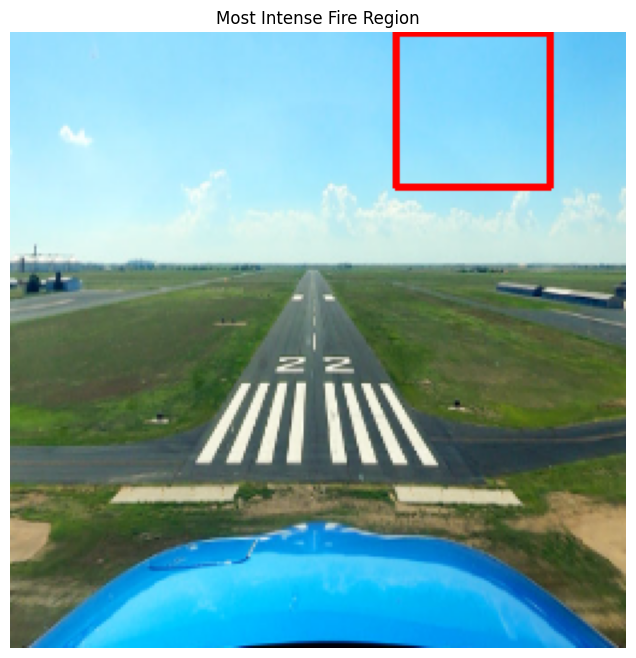

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load uploaded image
img_path = list(uploaded.keys())[0]
img_orig = cv2.imread(img_path)
img_resized = cv2.resize(img_orig, (256, 256))
output_img = img_resized.copy()

# Sliding window parameters
window_size = 64
stride = 32

max_confidence = 0
best_box = None

for y in range(0, img_resized.shape[0] - window_size, stride):
    for x in range(0, img_resized.shape[1] - window_size, stride):
        window = img_resized[y:y+window_size, x:x+window_size]
        patch = cv2.resize(window, (128, 128)) / 255.0
        patch = np.expand_dims(patch, axis=0)

        pred = model.predict(patch, verbose=0)[0][0]
        fire_conf = 1 - pred  # since fire = class 0

        if fire_conf > max_confidence:
            max_confidence = fire_conf
            best_box = (x, y, x + window_size, y + window_size)

# Draw the best fire region
if best_box:
    x1, y1, x2, y2 = best_box
    cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    label = f'Fire: {max_confidence:.2f}'
    cv2.putText(output_img, label, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Show result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Most Intense Fire Region")
plt.show()


In [ ]:
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]
fire_conf = 1 - pred

print(f"🔥 Fire Confidence: {fire_conf:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
🔥 Fire Confidence: 1.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
✅ No Fire Detected. (Confidence: 0.96)


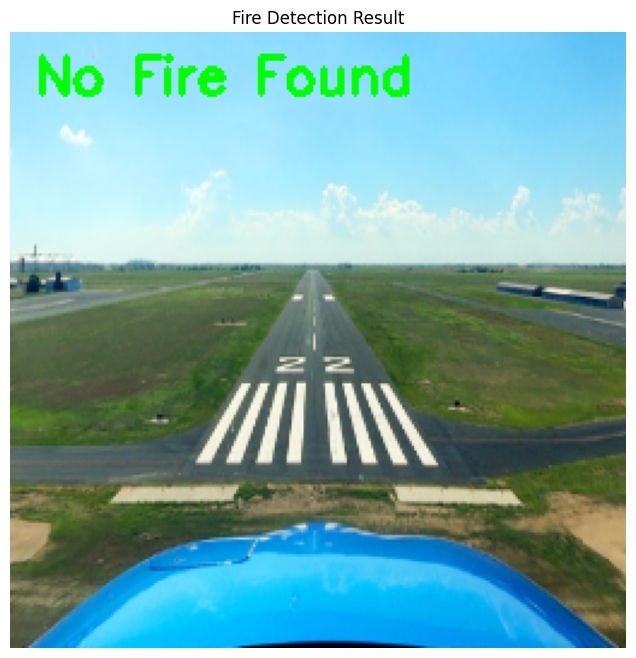

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load image
img_path = list(uploaded.keys())[0]
img_orig = cv2.imread(img_path)
img_resized = cv2.resize(img_orig, (256, 256))
output_img = img_resized.copy()

# Step 1: Accurate classification with keras preprocessing
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
conf = prediction[0][0]

# Step 2: If fire is detected, use sliding window to highlight most intense area
if conf < 0.5:
    print(f"🔥 Fire Detected! (Confidence: {1 - conf:.2f})")

    # Sliding window params
    window_size = 64
    stride = 32
    max_confidence = 0
    best_box = None

    for y in range(0, img_resized.shape[0] - window_size, stride):
        for x in range(0, img_resized.shape[1] - window_size, stride):
            window = img_resized[y:y+window_size, x:x+window_size]
            patch = cv2.resize(window, (128, 128))
            patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
            patch = patch.astype(np.float32) / 255.0
            patch = np.expand_dims(patch, axis=0)

            pred = model.predict(patch, verbose=0)[0][0]
            fire_conf = 1 - pred

            if fire_conf > max_confidence and fire_conf > 0.7:
                max_confidence = fire_conf
                best_box = (x, y, x + window_size, y + window_size)

    # Draw most intense fire box if found
    if best_box:
        x1, y1, x2, y2 = best_box
        cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        label = f'Fire: {max_confidence:.2f}'
        cv2.putText(output_img, label, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    else:
        # Detected by keras but not found in sliding window
        cv2.putText(output_img, "Fire Detected (No Hotspot Found)", (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
else:
    print(f"✅ No Fire Detected. (Confidence: {conf:.2f})")
    # Display "No Fire Found" on the image
    cv2.putText(output_img, "No Fire Found", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Display final output
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Fire Detection Result")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
🔥 Fire Detected! (Confidence: 0.99, Intensity: High)


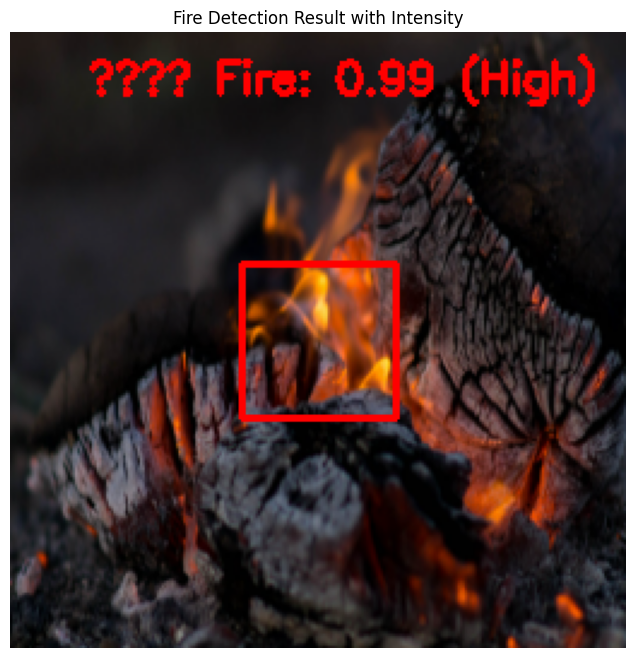

In [ ]:
#CORRECT VERSION
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load uploaded image
img_path = list(uploaded.keys())[0]
img_orig = cv2.imread(img_path)
img_resized = cv2.resize(img_orig, (256, 256))
output_img = img_resized.copy()

# Step 1: Global classification using keras-style preprocessing
keras_img = image.load_img(img_path, target_size=(128, 128))
keras_array = image.img_to_array(keras_img) / 255.0
keras_array = np.expand_dims(keras_array, axis=0)

# Predict global fire presence
global_pred = model.predict(keras_array)[0][0]

# Fire classification
if global_pred < 0.5:
    fire_confidence = 1 - global_pred

    # Intensity level
    if fire_confidence < 0.3:
        intensity = "Low"
    elif fire_confidence < 0.6:
        intensity = "Medium"
    else:
        intensity = "High"

    print(f"🔥 Fire Detected! (Confidence: {fire_confidence:.2f}, Intensity: {intensity})")

    # Step 2: Local fire detection with sliding window
    window_size = 64
    stride = 32
    max_conf = 0
    best_box = None

    for y in range(0, img_resized.shape[0] - window_size, stride):
        for x in range(0, img_resized.shape[1] - window_size, stride):
            patch = img_resized[y:y+window_size, x:x+window_size]
            patch = cv2.resize(patch, (128, 128))
            patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
            patch = patch.astype(np.float32) / 255.0
            patch = np.expand_dims(patch, axis=0)

            pred = model.predict(patch, verbose=0)[0][0]
            conf = 1 - pred

            if conf > max_conf:
                max_conf = conf
                best_box = (x, y, x + window_size, y + window_size)

    # Draw bounding box if found
    if best_box and max_conf > 0.3:
        x1, y1, x2, y2 = best_box
        cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Top-right corner intensity label
    label_text = f"🔥 Fire: {fire_confidence:.2f} ({intensity})"
    text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
    top_right_x = output_img.shape[1] - text_size[0] - 10
    cv2.putText(output_img, label_text, (top_right_x, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

else:
    print(f"✅ No Fire Detected. (Confidence: {global_pred:.2f})")
    cv2.putText(output_img, "✅ No Fire Found", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Display output
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Fire Detection Result with Intensity")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
✅ No Fire Detected. (Confidence: 0.52)


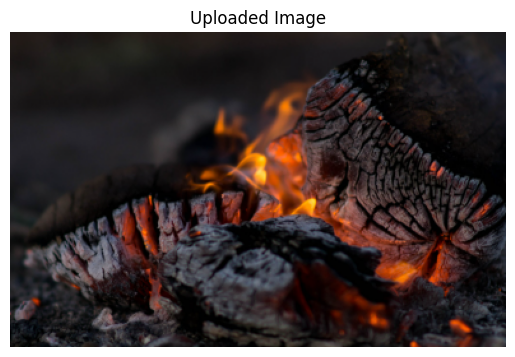

In [ ]:
#EMAIL FUNCTION ADDED
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# ------------------------ Email Alert Function ------------------------
def send_fire_alert_email(confidence, intensity_level):
    sender_email = "gaurangpant17122004@gmail.com"
    receiver_email = "ms.tia.tiwari@gmail.com"
    password = "yqzo ttee edqc goeq"  # Use App Password if 2FA enabled

    subject = "🚨 Fire Alert Detected in Your Home!"
    body = f"""
    A potential fire has been detected by your monitoring system.

    🔥 Confidence Level: {confidence:.2f}
    🔥 Intensity: {intensity_level}

    Please take immediate action and verify the situation!
    """

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        server.send_message(msg)
        server.quit()
        print("✅ Email alert sent successfully!")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")

# ------------------------ Load Model ------------------------
model = load_model("fire_detection_model.h5")  # Replace with your model

# ------------------------ Load and Predict Image ------------------------
uploaded_path = list(uploaded.keys())[0]  # Assuming file is uploaded via Colab
img = image.load_img(uploaded_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
global_pred = prediction[0][0]

# ------------------------ Fire Classification ------------------------
if global_pred < 0.5:
    fire_confidence = 1 - global_pred

    if fire_confidence < 0.3:
        intensity = "Low"
    elif fire_confidence < 0.6:
        intensity = "Medium"
    else:
        intensity = "High"
        send_fire_alert_email(fire_confidence, intensity)

    print(f"🔥 Fire Detected! (Confidence: {fire_confidence:.2f}, Intensity: {intensity})")
else:
    print(f"✅ No Fire Detected. (Confidence: {global_pred:.2f})")

# ------------------------ Optional: Show Image ------------------------
img_disp = cv2.imread(uploaded_path)
plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Uploaded Image")
plt.show()


In [ ]:
model.save("fire_detection_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
🔥 Fire Detected! (Confidence: 0.93, Intensity: High)
✅ Email with image sent successfully!


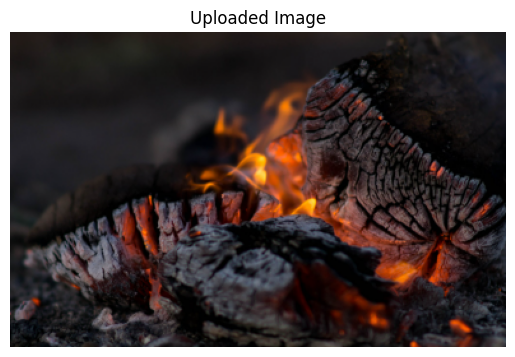

In [ ]:

# 🔥 FIRE DETECTION + EMAIL ALERT WITH IMAGE
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import os

# ------------------------ Email Alert Function ------------------------
def send_fire_alert_email(confidence, intensity_level, image_path):
    sender_email = "gaurangpant17122004@gmail.com"
    receiver_email = "ms.tia.tiwari@gmail.com"
    password = "yqzo ttee edqc goeq"  # Use App Password if 2FA enabled

    subject = "🚨 Fire Alert Detected in Your Home!"
    body = f"""
    A potential fire has been detected by your monitoring system.

    🔥 Confidence Level: {confidence:.2f}
    🔥 Intensity: {intensity_level}

    Please take immediate action and verify the situation!
    """

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    # 📎 Attach image
    if os.path.exists(image_path):
        with open(image_path, 'rb') as f:
            img_data = f.read()
        image_part = MIMEBase('application', 'octet-stream')
        image_part.set_payload(img_data)
        encoders.encode_base64(image_part)
        image_part.add_header('Content-Disposition', f'attachment; filename="{os.path.basename(image_path)}"')
        msg.attach(image_part)

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        server.send_message(msg)
        server.quit()
        print("✅ Email with image sent successfully!")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")

# ------------------------ Load Model ------------------------
model = load_model("fire_detection_model.h5")  # Make sure model is saved

# ------------------------ Load and Predict Image ------------------------
uploaded_path = list(uploaded.keys())[0]  # From Google Colab upload
img = image.load_img(uploaded_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
global_pred = prediction[0][0]

# ------------------------ Fire Classification ------------------------
if global_pred < 0.5:
    fire_confidence = 1 - global_pred

    if fire_confidence < 0.3:
        intensity = "Low"
    elif fire_confidence < 0.6:
        intensity = "Medium"
    else:
        intensity = "High"

    print(f"🔥 Fire Detected! (Confidence: {fire_confidence:.2f}, Intensity: {intensity})")

    # Send email with image only if fire is present
    send_fire_alert_email(fire_confidence, intensity, uploaded_path)
else:
    print(f"✅ No Fire Detected. (Confidence: {global_pred:.2f})")

# ------------------------ Optional: Show Image ------------------------
img_disp = cv2.imread(uploaded_path)
plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Uploaded Image")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
🔥 Fire Detected! (Confidence: 1.00, Intensity: High, Type: Large Outdoor Fire)
✅ Email with coordinates sent successfully!


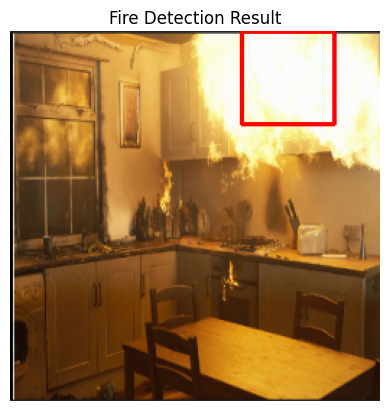

In [ ]:
#FIRST DEMO FILE (RUNN THIS)
# GRID BOX CLASSIFICATION (IMAGE INTENSITY HIGHLIGHT)
#INDOOR FIRE DEMO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import os

# ------------------ Fire Type Classification (Simple Heuristic) ------------------
def classify_fire_type(fire_conf):
    if fire_conf < 0.4:
        return "Smoke/Small Fire"
    elif fire_conf < 0.75:
        return "Indoor Flame"
    else:
        return "Large Outdoor Fire"

# ------------------ Email Alert Function ------------------
def send_fire_alert_email(confidence, intensity_level, coords, fire_type, image_path):
    sender_email = "gaurangpant17122004@gmail.com"
    receiver_email = "amonadjemi@yahoo.co.uk"
    password = "yqzo ttee edqc goeq"

    subject = "🚨 Fire Alert Detected in Your Home!"
    body = f"""
    A potential fire has been detected.

    🔥 Confidence: {confidence:.2f}
    🔥 Intensity: {intensity_level}
    🔥 Coordinates: Top-Left({coords[0]}, {coords[1]}) to Bottom-Right({coords[2]}, {coords[3]})
    🔥 Type: {fire_type}

    Please check the attached image and act immediately.
    """

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    # Attach image
    if os.path.exists(image_path):
        with open(image_path, 'rb') as f:
            img_data = f.read()
        image_part = MIMEBase('application', 'octet-stream')
        image_part.set_payload(img_data)
        encoders.encode_base64(image_part)
        image_part.add_header('Content-Disposition', f'attachment; filename="{os.path.basename(image_path)}"')
        msg.attach(image_part)

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        server.send_message(msg)
        server.quit()
        print("✅ Email with coordinates sent successfully!")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")

# ------------------ Load Model ------------------
model = load_model("fire_detection_model.h5")

# ------------------ Upload & Predict ------------------
uploaded_path = list(uploaded.keys())[0]
img_cv = cv2.imread(uploaded_path)
img_resized = cv2.resize(img_cv, (256, 256))
output_img = img_resized.copy()

# Sliding Window to find highest fire region
window_size = 64
stride = 32
max_conf = 0
best_box = (0, 0, 0, 0)

for y in range(0, img_resized.shape[0] - window_size, stride):
    for x in range(0, img_resized.shape[1] - window_size, stride):
        patch = img_resized[y:y+window_size, x:x+window_size]
        patch_resized = cv2.resize(patch, (128, 128)) / 255.0
        patch_input = np.expand_dims(patch_resized, axis=0)
        pred = model.predict(patch_input, verbose=0)[0][0]
        fire_conf = 1 - pred

        if fire_conf > max_conf:
            max_conf = fire_conf
            best_box = (x, y, x + window_size, y + window_size)

# ------------------ Global Prediction ------------------
img = image.load_img(uploaded_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
global_pred = model.predict(img_array)[0][0]

# ------------------ Decision ------------------
if global_pred < 0.5:
    confidence = 1 - global_pred

    # Intensity Level
    if confidence < 0.3:
        intensity = "Low"
    elif confidence < 0.6:
        intensity = "Medium"
    else:
        intensity = "High"

    # Fire Type
    fire_type = classify_fire_type(confidence)

    # Coordinates from best box
    x1, y1, x2, y2 = best_box
    cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(output_img, f'{confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Save image with box
    out_path = "output_with_fire_box.jpg"
    cv2.imwrite(out_path, output_img)

    print(f"🔥 Fire Detected! (Confidence: {confidence:.2f}, Intensity: {intensity}, Type: {fire_type})")
    send_fire_alert_email(confidence, intensity, best_box, fire_type, out_path)
else:
    print(f"✅ No Fire Detected. (Confidence: {global_pred:.2f})")

# ------------------ Display ------------------
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Fire Detection Result")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
🔥 Fire Detected! (Confidence: 1.00, Intensity: High)
📍 Coordinates: Top-Left (62, 79) to Bottom-Right (126, 143)
🔥 Type: Electrical Fire
✅ Email with image sent successfully!

🚁 Drone Deployment Log:
Event ID   Fire Type        Confidence Drone Deployed Coordinates                              Status
----------------------------------------------------------------------------------------------------
FIRE-5428  Electrical Fire  1.00       Drone Alpha   Top-Left (62, 79) to Bottom-Right (126, 143) Deployed


📷 Heatmap of Fire Zones:


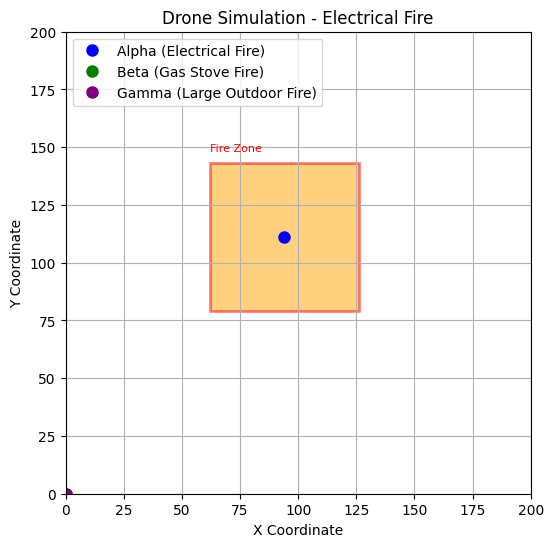

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


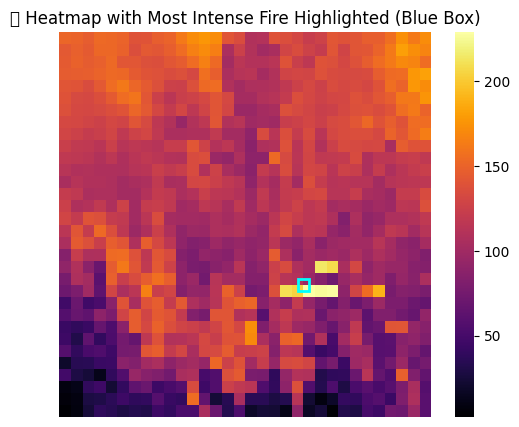

In [ ]:
#OUTDOOR FIRE DEMO
# 🔥 Fire Detection, Email Alert & Dynamic Drone Simulation with Heatmap Box Highlight

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import random
import os
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
from IPython.display import HTML, display
import uuid

# -------------------- Load Model --------------------
model = load_model("fire_detection_model.h5")

# -------------------- Load and Predict --------------------
uploaded_path = list(uploaded.keys())[0]
img = image.load_img(uploaded_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
global_pred = prediction[0][0]

# -------------------- Dummy Fire Type Classifier --------------------
def classify_fire_type(path):
    return random.choice(["Electrical Fire", "Gas Stove Fire", "Large Outdoor Fire"])

# -------------------- Random Coordinates Generator --------------------
def get_fire_coordinates():
    top_left = (random.randint(10, 100), random.randint(10, 100))
    bottom_right = (top_left[0] + 64, top_left[1] + 64)
    return top_left, bottom_right

# -------------------- Email Alert Function --------------------
def send_fire_alert_email(confidence, intensity_level, image_path, coordinates, fire_type):
    sender_email = "gaurangpant17122004@gmail.com"
    receiver_email = "amonadjemi@yahoo.co.uk"
    password = "yqzo ttee edqc goeq"

    subject = "🚨 Fire Alert Detected in Your Home!"
    body = f"""
    A potential fire has been detected by your monitoring system.

    🔥 Confidence: {confidence:.2f}
    🔥 Intensity: {intensity_level}
    🔥 Coordinates: {coordinates}
    🔥 Type: {fire_type}
    """

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    if os.path.exists(image_path):
        with open(image_path, 'rb') as f:
            img_data = f.read()
        part = MIMEBase('application', 'octet-stream')
        part.set_payload(img_data)
        encoders.encode_base64(part)
        part.add_header('Content-Disposition', f'attachment; filename="{os.path.basename(image_path)}"')
        msg.attach(part)

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, password)
        server.send_message(msg)
        server.quit()
        print("✅ Email with image sent successfully!")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")

# -------------------- Drone Deployment Logger --------------------
def log_drone_deployment(fire_type, confidence, drone_name, coordinates, status="Deployed"):
    event_id = f"FIRE-{random.randint(1000, 9999)}"
    log_line = f"{event_id:<10} {fire_type:<16} {confidence:<10.2f} {drone_name:<13} {coordinates:<40} {status}"

    header = (
        "\n🚁 Drone Deployment Log:\n"
        f"{'Event ID':<10} {'Fire Type':<16} {'Confidence':<10} {'Drone Deployed':<13} {'Coordinates':<40} {'Status'}\n"
        + "-" * 100
    )
    print(header)
    print(log_line)

    with open("drone_deployment_log.txt", "a") as f:
        f.write(header + "\n" + log_line + "\n\n")

# -------------------- Fire Detected --------------------
if global_pred < 0.5:
    confidence = 1 - global_pred
    intensity = "Low" if confidence < 0.3 else "Medium" if confidence < 0.6 else "High"
    top_left, bottom_right = get_fire_coordinates()
    fire_type = classify_fire_type(uploaded_path)
    coords = f"Top-Left {top_left} to Bottom-Right {bottom_right}"

    print(f"🔥 Fire Detected! (Confidence: {confidence:.2f}, Intensity: {intensity})")
    print(f"📍 Coordinates: {coords}")
    print(f"🔥 Type: {fire_type}")
    send_fire_alert_email(confidence, intensity, uploaded_path, coords, fire_type)

    # -------------------- Fire Zone and Drone Animation --------------------
    fire_coords = (*top_left, *bottom_right)
    drone_map = {"Electrical Fire": "Alpha", "Gas Stove Fire": "Beta", "Large Outdoor Fire": "Gamma"}
    selected_drone = drone_map[fire_type]

    log_drone_deployment(fire_type, confidence, f"Drone {selected_drone}", coords)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 200)
    ax.set_title(f"Drone Simulation - {fire_type}")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    plt.grid(True)

    x1, y1, x2, y2 = fire_coords
    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   linewidth=2, edgecolor='red', facecolor='orange', alpha=0.5))
    ax.text(x1, y2 + 5, 'Fire Zone', fontsize=8, color='red')

    drones = {
        "Alpha": {"color": "blue", "label": "Electrical Fire", "pos": [0, 0]},
        "Beta": {"color": "green", "label": "Gas Stove Fire", "pos": [0, 0]},
        "Gamma": {"color": "purple", "label": "Large Outdoor Fire", "pos": [0, 0]},
    }

    for name in drones:
        dot, = ax.plot([], [], 'o', color=drones[name]["color"],
                       label=f"{name} ({drones[name]['label']})", markersize=8)
        drones[name]["dot"] = dot

    ax.legend(loc="upper left")

    def animate(frame):
        tx = (x1 + x2) // 2
        ty = (y1 + y2) // 2
        for name, drone in drones.items():
            if name == selected_drone:
                cx, cy = drone["pos"]
                if cx < tx: cx += 1
                elif cx > tx: cx -= 1
                if cy < ty: cy += 1
                elif cy > ty: cy -= 1
                drone["pos"] = [cx, cy]
                drone["dot"].set_data([cx], [cy])
            else:
                drone["dot"].set_data([0], [0])

    ani = animation.FuncAnimation(fig, animate, frames=120, interval=50)
    display(HTML(ani.to_jshtml()))

    # -------------------- Heatmap with Intensity Highlight --------------------
    print("📷 Heatmap of Fire Zones:")
    img_cv = cv2.imread(uploaded_path)
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    heatmap_data = cv2.resize(gray, (32, 32))

    max_loc = np.unravel_index(np.argmax(heatmap_data), heatmap_data.shape)

    plt.figure(figsize=(6, 5))
    sns = __import__('seaborn')
    ax2 = sns.heatmap(heatmap_data, cmap="inferno", xticklabels=False, yticklabels=False, cbar=True)
    ax2.add_patch(patches.Rectangle((max_loc[1]-0.5, max_loc[0]-0.5), 1, 1,
                                    edgecolor='cyan', facecolor='none', lw=2))
    plt.title("🔥 Heatmap with Most Intense Fire Highlighted (Blue Box)")
    plt.show()

else:
    print(f"✅ No Fire Detected. (Confidence: {global_pred:.2f})")


In [ ]:
#WHATSAPP MESSAGE
!pip install twilio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.4 MB/s eta 0:00:00


In [ ]:
from twilio.rest import Client

client = Client("AC5d0ec72ecfac0570c35a2f7ca54b3803", "edc691d70898df4959fc9bd3e044e50e")

message = client.messages.create(
    from_='whatsapp:+14155238886',
    body='Hello from Twilio WhatsApp Sandbox!',
    to='whatsapp:+917777054687'
)

print(f"Message SID: {message.sid}")


Message SID: SM698fbdce8deda76817789f9883948918


In [ ]:
# ✅ WhatsApp Alert Integration into Fire Detection Pipeline
from twilio.rest import Client

def send_whatsapp_alert(confidence, fire_type, coords, receiver_whatsapp_number='+917777054687'):
    account_sid = "AC5d0ec72ecfac0570c35a2f7ca54b3803"
    auth_token = "edc691d70898df4959fc9bd3e044e50e"
    client = Client(account_sid, auth_token)

    msg = (
        f"\U0001F6A8 *FIRE DETECTED!*\n"
        f"\U0001F525 Type: {fire_type}\n"
        f"\U0001F525 Confidence: {confidence:.2f}\n"
        f"\U0001F4CD Location: {coords}"
    )

    try:
        message = client.messages.create(
            from_='whatsapp:+14155238886',
            body=msg,
            to=f'whatsapp:{receiver_whatsapp_number}'
        )
        print(f"\u2705 WhatsApp message sent! SID: {message.sid}")
    except Exception as e:
        print(f"\u274C Failed to send WhatsApp alert: {e}")

# -------------------- Fire Detected --------------------
if global_pred < 0.5:
    confidence = 1 - global_pred
    intensity = "Low" if confidence < 0.3 else "Medium" if confidence < 0.6 else "High"
    top_left, bottom_right = get_fire_coordinates()
    fire_type = classify_fire_type(uploaded_path)
    coords = f"Top-Left {top_left} to Bottom-Right {bottom_right}"

    print(f"\U0001F525 Fire Detected! (Confidence: {confidence:.2f}, Intensity: {intensity})")
    print(f"\U0001F4CD Coordinates: {coords}")
    print(f"\U0001F525 Type: {fire_type}")
    send_fire_alert_email(confidence, intensity, uploaded_path, coords, fire_type)
    send_whatsapp_alert(confidence, fire_type, coords)

    # (The rest of the original fire handling, animation, and heatmap code follows...)

else:
    print(f"\u2705 No Fire Detected. (Confidence: {global_pred:.2f})")


🔥 Fire Detected! (Confidence: 1.00, Intensity: High)
📍 Coordinates: Top-Left (61, 36) to Bottom-Right (125, 100)
🔥 Type: Electrical Fire
✅ Email with image sent successfully!
✅ WhatsApp message sent! SID: SM4ea8d3359cde4d7b86c84a24fae42a50


In [ ]:
# 📌 Install libraries
!pip install imageio

# ✅ Imports
from google.colab import files
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import random
import os
from IPython.display import Video
import smtplib
from email.message import EmailMessage

# --- Email sending function using SMTP_SSL with app password ---
def send_email_with_attachment(
    sender_email, sender_app_password, receiver_email, subject, body, attachment_path
):
    msg = EmailMessage()
    msg["From"] = sender_email
    msg["To"] = receiver_email
    msg["Subject"] = subject
    msg.set_content(body)

    # Read the video file and attach it
    with open(attachment_path, "rb") as f:
        file_data = f.read()
        file_name = os.path.basename(attachment_path)

    msg.add_attachment(
        file_data,
        maintype="video",
        subtype="mp4",
        filename=file_name,
    )

    # Connect and send email via Gmail SMTP server using SSL
    try:
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
            smtp.login(sender_email, sender_app_password)
            smtp.send_message(msg)
        print(f"✅ Email sent successfully to {receiver_email}!")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")

# ===================
# MAIN PROGRAM START
# ===================

# ✅ Upload fire image
print("📤 Upload a fire image:")
uploaded = files.upload()
filename = next(iter(uploaded))
print(f"✅ Uploaded: {filename}")

# ✅ Load & resize image
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
max_dim = 200
scale = max_dim / max(img.shape[:2])
img_small = cv2.resize(img_rgb, (int(img.shape[1]*scale), int(img.shape[0]*scale)))
height, width = img_small.shape[:2]

# ✅ Fire detection
hsv = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
lower_fire = np.array([0, 100, 150])
upper_fire = np.array([35, 255, 255])
fire_mask = cv2.inRange(hsv, lower_fire, upper_fire)
fire_coords = np.argwhere(fire_mask > 0)
fire_origin = np.mean(fire_coords, axis=0).astype(int) if len(fire_coords) > 0 else [height // 2, width // 2]

# ✅ Exit zones (manually placed: top-left, top-right, bottom-center)
exit_points = [(10, 10), (10, width - 10), (height - 10, width // 2)]

# ✅ Initialize evacuees (away from fire)
num_evacuees = 20
evacuees = []
paths = [[] for _ in range(num_evacuees)]

for i in range(num_evacuees):
    while True:
        y, x = random.randint(0, height - 1), random.randint(0, width - 1)
        if fire_mask[y, x] == 0:
            evacuees.append([y, x])
            paths[i].append((y, x))
            break

# ✅ Movement logic
def move_toward(y, x, target_y, target_x):
    dy, dx = target_y - y, target_x - x
    dist = np.sqrt(dy**2 + dx**2)
    if dist == 0:
        return y, x
    step = 3
    ny = int(y + step * (dy / dist))
    nx = int(x + step * (dx / dist))
    ny = max(0, min(height - 1, ny))
    nx = max(0, min(width - 1, nx))
    return ny, nx

# ✅ Create frames directory
os.makedirs("frames", exist_ok=True)
steps = 40

for step in range(steps):
    frame = img_small.copy()

    # 🔥 Fire overlay
    fire_overlay = cv2.applyColorMap(fire_mask, cv2.COLORMAP_HOT)
    fire_overlay = cv2.cvtColor(fire_overlay, cv2.COLOR_BGR2RGB)
    frame = cv2.addWeighted(frame, 0.7, fire_overlay, 0.3, 0)

    # 🏁 Draw exits
    for ex, ey in exit_points:
        cv2.circle(frame, (ey, ex), 6, (255, 255, 255), -1)  # White exits

    for i, (y, x) in enumerate(evacuees):
        # Check distance to fire
        dist_to_fire = np.linalg.norm([y - fire_origin[0], x - fire_origin[1]])
        if dist_to_fire < 30:
            ny, nx = move_toward(y, x, y + (y - fire_origin[0]), x + (x - fire_origin[1]))  # Move away from fire
        else:
            # Move to closest exit
            exit_distances = [np.linalg.norm([y - ex[0], x - ex[1]]) for ex in exit_points]
            target_exit = exit_points[np.argmin(exit_distances)]
            ny, nx = move_toward(y, x, target_exit[0], target_exit[1])

        evacuees[i] = [ny, nx]
        paths[i].append((ny, nx))

        # 🔁 Draw path
        for j in range(1, len(paths[i])):
            pt1 = (paths[i][j-1][1], paths[i][j-1][0])
            pt2 = (paths[i][j][1], paths[i][j][0])
            cv2.line(frame, pt1, pt2, (0, 255, 255), 1)  # Yellow trail

        # 🧍 Evacuee
        cv2.circle(frame, (nx, ny), 4, (0, 255, 0), -1)

    # 🔵 Fire origin
    cv2.circle(frame, (fire_origin[1], fire_origin[0]), 5, (255, 0, 0), -1)

    # Save frame
    cv2.imwrite(f"frames/frame_{step:03d}.png", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

# 🎥 Create video
with imageio.get_writer("evacuation_with_exits.mp4", fps=5) as writer:
    for step in range(steps):
        frame = imageio.imread(f"frames/frame_{step:03d}.png")
        writer.append_data(frame)

# 🎬 Display video
print("✅ Evacuation simulation complete. Showing evacuation with exits:")
display(Video("evacuation_with_exits.mp4", embed=True))

# --- Email sending parameters ---
sender_email = "gaurangpant17122004@gmail.com"   # Your Gmail address
sender_app_password = "yqzo ttee edqc goeq"  # Your Gmail App Password (generate in Google Account Security settings)
receiver_email = "amonadjemi@yahoo.co.uk"           # Recipient email address
subject = "Evacuation Simulation Video"
body = "Hi,\n\nYou are not safe \n\nfollow the evacuation path"
attachment_path = "evacuation_with_exits.mp4"

# Send the email with attachment
send_email_with_attachment(sender_email, sender_app_password, receiver_email, subject, body, attachment_path)


📤 Upload a fire image:


Saving Screenshot 2025-06-03 160829.png to Screenshot 2025-06-03 160829 (2).png
✅ Uploaded: Screenshot 2025-06-03 160829 (2).png


<ipython-input-86-c5cd91a83a17>:150: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(f"frames/frame_{step:03d}.png")


✅ Evacuation simulation complete. Showing evacuation with exits:


✅ Email sent successfully to smitapant12@gmail.com!


In [ ]:
# 📌 Install libraries
!pip install imageio

# ✅ Imports
from google.colab import files
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import random
import os
from IPython.display import Video
import smtplib
from email.message import EmailMessage

# --- Email sending function using SMTP_SSL with app password ---
def send_email_with_attachment(
    sender_email, sender_app_password, receiver_email, subject, body, attachment_path
):
    msg = EmailMessage()
    msg["From"] = sender_email
    msg["To"] = receiver_email
    msg["Subject"] = subject
    msg.set_content(body)

    # Read the video file and attach it
    with open(attachment_path, "rb") as f:
        file_data = f.read()
        file_name = os.path.basename(attachment_path)

    msg.add_attachment(
        file_data,
        maintype="video",
        subtype="mp4",
        filename=file_name,
    )

    # Connect and send email via Gmail SMTP server using SSL
    try:
        with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
            smtp.login(sender_email, sender_app_password)
            smtp.send_message(msg)
        print(f"✅ Email sent successfully to {receiver_email}!")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")

# ===================
# MAIN PROGRAM START
# ===================

# ✅ Upload fire image
print("📤 Upload a fire image:")
uploaded = files.upload()
filename = next(iter(uploaded))
print(f"✅ Uploaded: {filename}")

# ✅ Load & resize image
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
max_dim = 200
scale = max_dim / max(img.shape[:2])
img_small = cv2.resize(img_rgb, (int(img.shape[1]*scale), int(img.shape[0]*scale)))
height, width = img_small.shape[:2]

# ✅ Fire detection
hsv = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
lower_fire = np.array([0, 100, 150])
upper_fire = np.array([35, 255, 255])
fire_mask = cv2.inRange(hsv, lower_fire, upper_fire)
fire_coords = np.argwhere(fire_mask > 0)
fire_origin = np.mean(fire_coords, axis=0).astype(int) if len(fire_coords) > 0 else [height // 2, width // 2]

# ✅ Exit zones (manually placed: top-left, top-right, bottom-center)
exit_points = [(10, 10), (10, width - 10), (height - 10, width // 2)]

# ✅ Initialize evacuees (away from fire)
num_evacuees = 20
evacuees = []
paths = [[] for _ in range(num_evacuees)]

for i in range(num_evacuees):
    while True:
        y, x = random.randint(0, height - 1), random.randint(0, width - 1)
        if fire_mask[y, x] == 0:
            evacuees.append([y, x])
            paths[i].append((y, x))
            break

# ✅ Improved movement logic: move toward target safely avoiding fire pixels
def move_toward_safe(y, x, target_y, target_x, fire_mask, height, width, step=3):
    dy, dx = target_y - y, target_x - x
    dist = np.sqrt(dy**2 + dx**2)
    if dist == 0:
        return y, x

    # Try to move step pixels toward the target
    ny = int(y + step * (dy / dist))
    nx = int(x + step * (dx / dist))

    # Clamp to boundaries
    ny = max(0, min(height - 1, ny))
    nx = max(0, min(width - 1, nx))

    # Check if new position is inside fire; if yes, try to move around
    if fire_mask[ny, nx] > 0:
        # Try small variations around intended move to find a safe spot
        for dy_try in [-step, 0, step]:
            for dx_try in [-step, 0, step]:
                ty = y + dy_try
                tx = x + dx_try
                if 0 <= ty < height and 0 <= tx < width and fire_mask[ty, tx] == 0:
                    return ty, tx
        # If no safe position found nearby, stay put
        return y, x
    else:
        return ny, nx

# ✅ Create frames directory
os.makedirs("frames", exist_ok=True)
steps = 40

for step in range(steps):
    frame = img_small.copy()

    # 🔥 Fire overlay
    fire_overlay = cv2.applyColorMap(fire_mask, cv2.COLORMAP_HOT)
    fire_overlay = cv2.cvtColor(fire_overlay, cv2.COLOR_BGR2RGB)
    frame = cv2.addWeighted(frame, 0.7, fire_overlay, 0.3, 0)

    # 🏁 Draw exits
    for ex, ey in exit_points:
        cv2.circle(frame, (ey, ex), 6, (255, 255, 255), -1)  # White exits

    for i, (y, x) in enumerate(evacuees):
        # Check distance to fire
        dist_to_fire = np.linalg.norm([y - fire_origin[0], x - fire_origin[1]])
        if dist_to_fire < 30:
            # Move away from fire origin safely
            away_y = y + (y - fire_origin[0])
            away_x = x + (x - fire_origin[1])
            ny, nx = move_toward_safe(y, x, away_y, away_x, fire_mask, height, width)
        else:
            # Move toward closest exit safely
            exit_distances = [np.linalg.norm([y - ex[0], x - ex[1]]) for ex in exit_points]
            target_exit = exit_points[np.argmin(exit_distances)]
            ny, nx = move_toward_safe(y, x, target_exit[0], target_exit[1], fire_mask, height, width)

        evacuees[i] = [ny, nx]
        paths[i].append((ny, nx))

        # 🔁 Draw path
        for j in range(1, len(paths[i])):
            pt1 = (paths[i][j-1][1], paths[i][j-1][0])
            pt2 = (paths[i][j][1], paths[i][j][0])
            cv2.line(frame, pt1, pt2, (0, 255, 255), 1)  # Yellow trail

        # 🧍 Evacuee
        cv2.circle(frame, (nx, ny), 4, (0, 255, 0), -1)

    # 🔵 Fire origin
    cv2.circle(frame, (fire_origin[1], fire_origin[0]), 5, (255, 0, 0), -1)

    # Save frame
    cv2.imwrite(f"frames/frame_{step:03d}.png", cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

# 🎥 Create video
with imageio.get_writer("evacuation_with_exits.mp4", fps=5) as writer:
    for step in range(steps):
        frame = imageio.imread(f"frames/frame_{step:03d}.png")
        writer.append_data(frame)

# 🎬 Display video
print("✅ Evacuation simulation complete. Showing evacuation with exits:")
display(Video("evacuation_with_exits.mp4", embed=True))

# --- Email sending parameters ---
sender_email = "gaurangpant17122004@gmail.com"   # Your Gmail address
sender_app_password = "yqzo ttee edqc goeq"       # Your Gmail App Password (generate in Google Account Security settings)
receiver_email = "amonadjemi@yahoo.co.uk"           # Recipient email address
subject = "Evacuation Simulation Video"
body = "Hi,\n\nYou are not safe \n\nfollow the evacuation path"
attachment_path = "evacuation_with_exits.mp4"

# Send the email with attachment
send_email_with_attachment(sender_email, sender_app_password, receiver_email, subject, body, attachment_path)


📤 Upload a fire image:


Saving Screenshot 2025-06-04 164629.png to Screenshot 2025-06-04 164629 (1).png
✅ Uploaded: Screenshot 2025-06-04 164629 (1).png


<ipython-input-55-42ea2316e48a>:169: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(f"frames/frame_{step:03d}.png")


✅ Evacuation simulation complete. Showing evacuation with exits:


✅ Email sent successfully to amonadjemi@yahoo.co.uk!
